In [0]:
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN,GRU,LSTM,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#make the original data
series =np.sin((0.1*np.arange(400))**2)

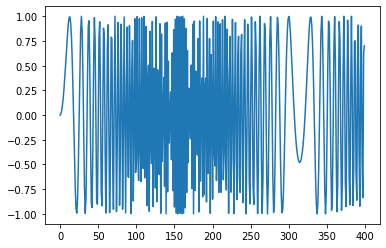

In [3]:
plt.plot(series)
plt.show()

In [47]:
### build the dataset
# let's see if we can use T past values to predict the next value
T =10
D=1
X =[]
Y=[]
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape,'Y.shape', Y.shape)

X.shape (390, 10) Y.shape (390,)


In [48]:
###try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer= Adam(lr=0.01)
)


#train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs =80,
    validation_data=(X[-N//2:],Y[-N//2:])
)

Epoch 1/80
7/7 [==============================] - 0s 20ms/step - loss: 2.1040 - val_loss: 1.1971
Epoch 2/80
7/7 [==============================] - 0s 6ms/step - loss: 1.7541 - val_loss: 1.1294
Epoch 3/80
7/7 [==============================] - 0s 6ms/step - loss: 1.5339 - val_loss: 1.0811
Epoch 4/80
7/7 [==============================] - 0s 6ms/step - loss: 1.3134 - val_loss: 1.0207
Epoch 5/80
7/7 [==============================] - 0s 6ms/step - loss: 1.1575 - val_loss: 0.9635
Epoch 6/80
7/7 [==============================] - 0s 6ms/step - loss: 1.0189 - val_loss: 0.9093
Epoch 7/80
7/7 [==============================] - 0s 6ms/step - loss: 0.9175 - val_loss: 0.8448
Epoch 8/80
7/7 [==============================] - 0s 6ms/step - loss: 0.8306 - val_loss: 0.7929
Epoch 9/80
7/7 [==============================] - 0s 6ms/step - loss: 0.7619 - val_loss: 0.7479
Epoch 10/80
7/7 [==============================] - 0s 6ms/step - loss: 0.7104 - val_loss: 0.7095
Epoch 11/80
7/7 [=====================

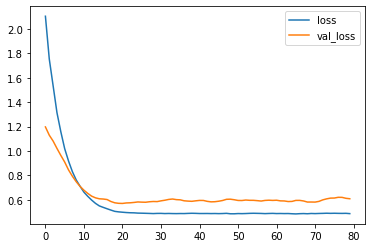

In [51]:
#Plot loss per iteration
plt.plot(r.history['loss'], label= 'loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


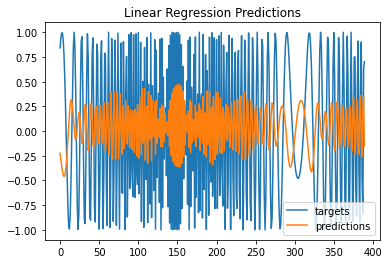

In [52]:
#One-step forecast using true targets
# Note: even the one-step forecast fails badly

outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

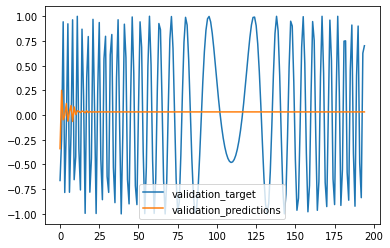

In [57]:
# Multi-step forecast
validation_target=Y[-N//2:]
validation_predictions=[]

#last train input
last_x = X[-N//2]
while len (validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1))[0,0]

  #update the prediction list
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

plt.plot(validation_target, label='validation_target')
plt.plot(validation_predictions, label='validation_predictions')
plt.legend()
plt.show()

In [76]:
### Now try RNN/LSTM model
X = X.reshape(-1,T,1) #make it N x T x D

#make the RNN
i = Input(shape=(T,D))
x = SimpleRNN(10)(i)
x = Dense(1) (x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.05),
)

#train the model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size = 32,
    epochs =200,
    validation_data=(X[-N//2:],Y[-N//2:]),
)


Epoch 1/200
7/7 [==============================] - 0s 30ms/step - loss: 0.7293 - val_loss: 0.7577
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 0.5098 - val_loss: 0.6805
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4868 - val_loss: 0.5831
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 0.5201 - val_loss: 0.5585
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4999 - val_loss: 0.5800
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4789 - val_loss: 0.5913
Epoch 7/200
7/7 [==============================] - 0s 11ms/step - loss: 0.4527 - val_loss: 0.5357
Epoch 8/200
7/7 [==============================] - 0s 12ms/step - loss: 0.3992 - val_loss: 0.6528
Epoch 9/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4097 - val_loss: 0.4651
Epoch 10/200
7/7 [==============================] - 0s 12ms/step - loss: 0.3595 - val_loss: 0.5238
Epoch 11/200
7/7 [=

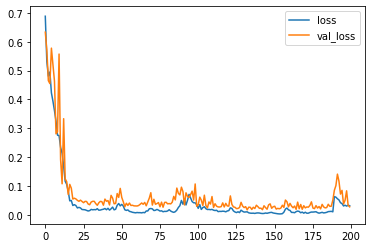

In [69]:
#Plot loss per iteration
plt.plot(r.history['loss'], label= 'loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


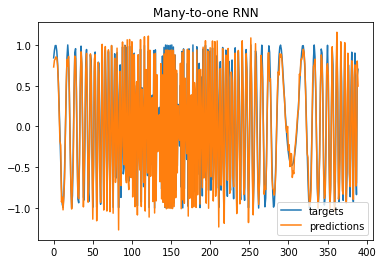

In [70]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Many-to-one RNN')
plt.legend()
plt.show()

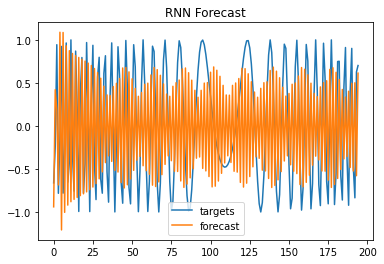

In [71]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()

In [72]:
### Now try RNN/LSTM model
X = X.reshape(-1,T,1) #make it N x T x D

#make the RNN
i = Input(shape=(T,D))
x = LSTM(10)(i)
x = Dense(1) (x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.05),
)

#train the model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size = 32,
    epochs =200,
    validation_data=(X[-N//2:],Y[-N//2:]),
)


Epoch 1/200
7/7 [==============================] - 0s 50ms/step - loss: 0.5241 - val_loss: 0.5641
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.4976 - val_loss: 0.5386
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.4579 - val_loss: 0.5157
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.3771 - val_loss: 0.5583
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 0.2930 - val_loss: 0.4196
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 0.2141 - val_loss: 0.2865
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 0.1519 - val_loss: 0.2443
Epoch 8/200
7/7 [==============================] - 0s 8ms/step - loss: 0.1012 - val_loss: 0.2073
Epoch 9/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0977 - val_loss: 0.1671
Epoch 10/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0601 - val_loss: 0.1218
Epoch 11/200
7/7 [==========

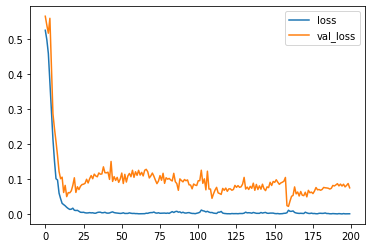

In [73]:
#Plot loss per iteration
plt.plot(r.history['loss'], label= 'loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


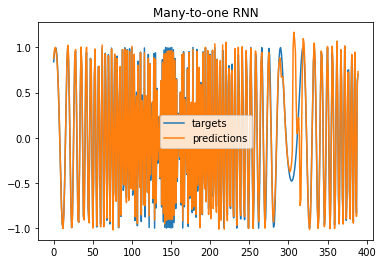

In [74]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Many-to-one RNN')
plt.legend()
plt.show()

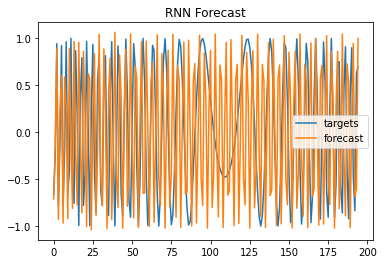

In [75]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()